In [1]:
from skimage.color import rgb2gray, rgb2hsv
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
import math
import os
import sys

### Localization

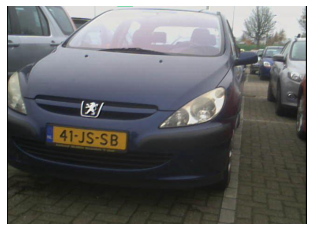

In [2]:
# Path to the image 
file_name = "plates/plate2.png"
image = plt.imread(file_name)
plt.axis('off')
plt.imshow(image)

(-0.5, 1368.5, 992.5, -0.5)

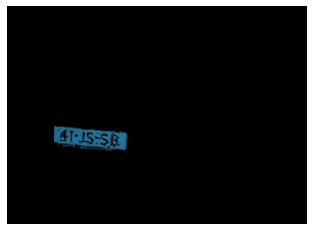

In [4]:
# detect yellow
img = cv2.imread(file_name)

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# mask for yellow color
mask = cv2.inRange(hsv, (17, 100, 50), (30, 255,255)) 

yellow = cv2.bitwise_and(img,img, mask= mask)    

plt.imshow(yellow)
plt.axis('off')

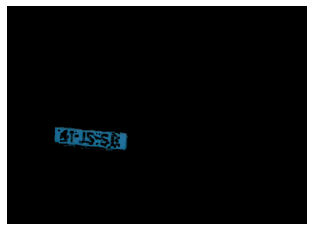

In [5]:
# erode twice with different kernels
# get rid of some yellow

kernel = np.ones((2,2), np.uint8) 
img_erode_1 = cv2.erode(yellow, kernel, iterations=3) 
#plt.imshow(img_erode_1)
kernel_2 = np.ones((1,1), np.uint8) 
img_erode = cv2.erode(img_erode_1, kernel_2, iterations=1) 
plt.axis('off')
plt.imshow(img_erode)

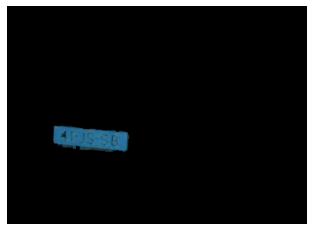

In [6]:
#dilate

kernel = np.ones((3,3), np.uint8) 
img_dilation = cv2.dilate(img_erode, kernel, iterations=5) #7
plt.axis('off')
plt.imshow(img_dilation)

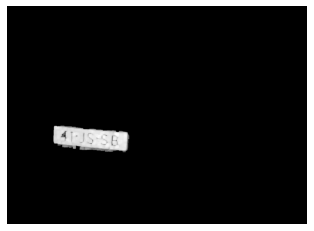

In [7]:
# turn the image into gray

gray = rgb2gray(img_dilation)
plt.axis('off')
plt.imshow(gray, cmap='gray')

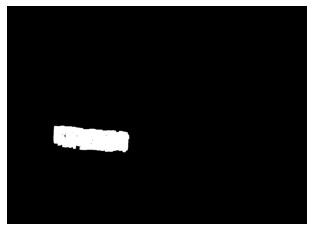

In [8]:
# turn the image into black and white

val = np.mean(gray)

for i in range(len(gray)):
    for j in range(len(gray[0])):
        if(gray[i,j] < val):
            gray[i,j] = 0
        else:
            gray[i,j] = 1
plt.axis('off')            
plt.imshow(gray, cmap='gray')

In [9]:
# Go row by row and compute sum for each row
# take the index of a row with the max sum

sum_rows = np.zeros(len(gray))

for i in range(len(gray)):
    sum_rows[i] = np.sum(gray[i,:])
max_row = np.argmax(sum_rows)

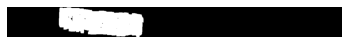

In [10]:
# go up and down from the max row until we encounter black row
begin_row = max_row-1
end_row = max_row+1

while(begin_row >= 0):
    if(np.sum(gray[begin_row,:]) == 0):
        break;
    else:
        begin_row = begin_row -1
        
while(end_row < len(gray)):
    if(np.sum(gray[end_row,:]) == 0):
        break;
    else:
        end_row = end_row + 1  
    
gray = gray[begin_row : end_row, :]
plt.axis('off')
plt.imshow(gray, cmap='gray')

In [11]:
# Go column by column and compute sum for each column
# take the index of a column with the max sum
sum_columns = np.zeros(len(gray[0]))

for i in range(len(gray[0])):
    sum_columns[i] = np.sum(gray[:,i])
max_column = np.argmax(sum_columns)

211 558


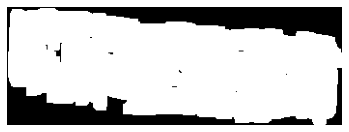

In [12]:
# go left and right from the max column until we encounter black column
begin_column = max_column-1
end_column = max_column+1

while(begin_column >= 0):
    if(np.sum(gray[:,begin_column]) == 0):
        break
    else:
        begin_column = begin_column -1
        
while(end_column < len(gray[0])):
    if(np.sum(gray[:,end_column]) == 0):
        break
    else:
        end_column = end_column + 1  

print(begin_column, end_column)
gray = gray[:, begin_column : end_column]

res_image = img[begin_row : end_row , begin_column : end_column, :]
plt.axis('off')
plt.imshow(gray, cmap='gray')
#plt.imshow(res_image)

### Rotation

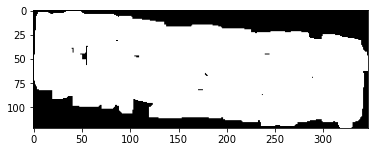

In [13]:
hsv = cv2.cvtColor(res_image, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (17, 85, 50), (30, 255, 255))
res_yellow = cv2.bitwise_and(res_image,res_image, mask = mask) 
plt.imshow(gray, cmap='gray')

In [14]:
interv = int(len(gray[0])/8)
arr = np.zeros(interv)

for i in range(interv):
    arr[i] = np.sum(gray[:,i])
    
begin_col = np.argmax(arr)
begin_row = len(gray)-1

while(gray[begin_row,begin_col] == 0):
    begin_row = begin_row-1

print(begin_col)
print(begin_row)


42
98


In [15]:
i = len(gray[0])-1
j=0
arr = np.zeros(interv)
while(j < interv):
    arr[j] = np.sum(gray[:,i])
    i=i-1
    j=j+1
end_col = len(gray[0])-1-np.argmax(arr)

end_row = len(gray)-1
while(gray[end_row,end_col] == 0):
    end_row = end_row-1
print(end_col)
print(end_row)

319
121


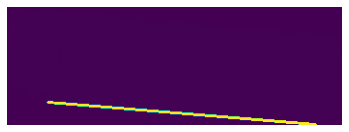

In [16]:
#Draw a line
x1 = begin_col
y1 = begin_row 
x2 = end_col
y2 = end_row

start_point = (x1, y1)
end_point = (x2, y2)
color = (255, 0, 0) 
line_image = cv2.line(gray, start_point, end_point, color, 2) 

plt.axis('off')
#plt.imshow(line_image)
plt.imshow(gray)

In [17]:
#Compute the angle of the lne
angle = math.atan2(x2-x1, y2-y1)
angle = angle * 180 / 3.14
print(angle)

85.29671865783286


In [18]:
# Compute rotation
rotation = 0
if angle > 90:
    rotation = -(angle - 91)
if angle < -90:
    rotation = -(angle + 91)
    
elif(int(angle) < 90):
    rotation = (90-angle)
    
print(rotation)

4.703281342167145


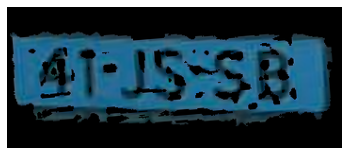

In [19]:
# Rotate the image
rotated = ndimage.rotate(res_image, rotation)
res_yellow = ndimage.rotate(res_yellow, rotation)
plt.axis('off')
plt.imshow(res_yellow)

### Crop

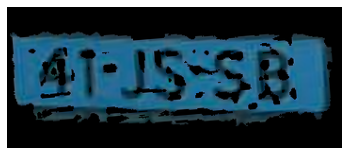

In [20]:
plt.axis('off')
plt.imshow(res_yellow)

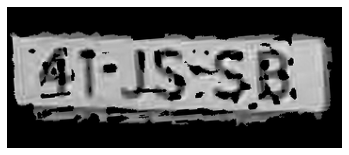

In [21]:
gray = rgb2gray(res_yellow)
plt.axis('off')
plt.imshow(gray, cmap='gray')

In [22]:
# Crop the picture from top and bottom
# based on the mean value of a picture
try:
    
    val = np.around(np.mean(gray[:][:]),5)#6, 5

    i = 0
    b = 0
    e = len(gray)-1

    while(i < len(gray)):
        if(np.mean(gray[i,:]) > val):
            b = i
            break
        i = i + 1

    i = len(gray)-1
    while(i >= 0):
        if(np.mean(gray[i,:]) > val):
            e = i
            break   
        i = i - 1

    b = b - 2
    while(b < 0):
        b = b + 1
    
    e = e + 2
    while(e >= len(gray)):
        e = e - 1
    print(val)
    rotated = rotated[b:e,:]
except IndexError:
    pass

0.15582


### Make plate black and white

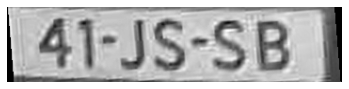

In [23]:
gray = rgb2gray(rotated)
plt.axis('off')
plt.imshow(gray, cmap='gray')

In [24]:
# Find the value we will use to turn picture into black and white
val = np.around(np.mean(gray[:][:]),3) #3
print(val)

0.313


(80, 356)


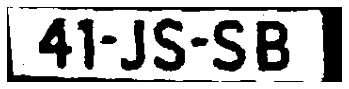

In [25]:
# From gray to black and white

for i in range(len(gray)):
    for j in range(len(gray[0])):
        if(gray[i][j] < val):
            gray[i][j] = 0
        else:
            gray[i][j] = 1
            
plt.axis('off')            
plt.imshow(gray, cmap='gray')
print(gray.shape)

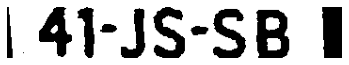

In [26]:
# We take 1/6 of the plate from top and bottom and 
# turn them to white to reduce the "noise"
#interval = int(len(gray)/7)

interval = int(len(gray)/6)

gray = gray[interval:,:]
gray = gray[:len(gray)-interval,:]

plt.axis('off')
plt.imshow(gray, cmap='gray')

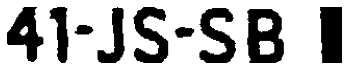

In [27]:
# Remove the black "noise" from the left part of the plate

interval = int(len(gray[0])/7)
j = interval
while(j >= 0):
    j = j - 1
    if(np.sum(gray[:,j]) < len(gray)-3):
        break

while(j >= 0):
    j = j - 1
    if(np.sum(gray[:,j]) > len(gray)-4):
        j = j + 1
        break
        
if(j <= 0):
    j = 2
    
gray = gray[:,j:]
plt.axis('off')
plt.imshow(gray, cmap='gray')

In [28]:
print(gray.shape)

(54, 322)


In [29]:
# Change size of the plate if it is too small
if(len(gray) <=21):
    dim = (len(gray[0])+15, len(gray)+15) 
    gray = cv2.resize(gray, dim)
elif(len(gray) <=32):
    dim = (len(gray[0])+10, len(gray)+10) 
    gray = cv2.resize(gray, dim)

### Character localization

In [30]:
# Locate the characters

black = gray

#Calculate value of threshold
thresh = len(black)-5

begin_col = 0
end_col = 0
box = 0
bb = np.zeros((8,2))
start = 0

while box < 8:
    for i in range(start, len(black[0])):
        if(np.sum(black[:,i]) <= thresh):
            begin_col = i;
            break;


    for i in range(begin_col, len(black[0])):
        if(np.sum(black[:,i]) >= len(black)-3):
            end_col = i;
            break;
    bb[box, 0] = begin_col
    bb[box, 1] = end_col
    box = box + 1
    start = end_col
    
bb = np.asarray(bb, dtype=np.int32)

In [31]:
#add all characters to the list

char1=[]; char2=[]; char3=[]; char4=[]; char5=[]; char6=[]; char7=[]; char8=[]
char_list = [char1, char2, char3, char4, char5, char6, char7, char8]
for i in range(0,8):
    char_list[i] = gray[:  , bb[i, 0] : bb[i, 1]]

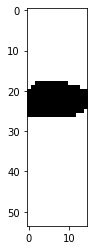

In [32]:
#show a character of char_list[i]
plt.imshow(char_list[2], cmap='gray')

In [33]:
#Crop from top and bottom

for i in range(0,8):
    char = char_list[i]

    # look for the row with the most black pixels
    sum_rows = np.zeros(len(char))
    for j in range(len(char)):
        sum_rows[j] = np.sum(char[j,:])
    min_row = np.argmin(sum_rows)
   
    begin_row = min_row-1
    end_row = min_row+1

    while(begin_row >= 0):
        if(np.sum(char[begin_row,:]) == len(char[0])):
            begin_row = begin_row +1
            break;
        else:
            begin_row = begin_row -1
            
    while(begin_row < 0):
        begin_row = begin_row + 1
    
       
    while(end_row < len(char)):
        if(np.sum(char[end_row,:]) == len(char[0])):
            break;
        else:
            end_row = end_row + 1 
    while(end_row >= len(char)):
        end_row = end_row-1
    
            
    if(np.abs(end_row - begin_row) < 8):             # if a character is a hyphen
        char_list[i] = np.zeros((8,8))
    else:
        char_list[i] = char[begin_row:end_row,:]


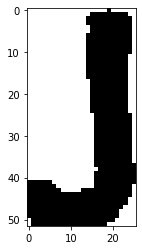

In [34]:
#show a character of char_list[i]
plt.imshow(char_list[3], cmap='gray')

In [35]:
# save characters in the corresponding folder
for i in range(0,8):
        plt.imsave('D:/try/'+str(i)+'.png', char_list[i], cmap='gray')